# Imports

In [1]:
import numpy as np
import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report

from sklearn.feature_extraction import text
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

import random
import tqdm
import os
import re

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# from torch.utils.tensorboard import SummaryWriter

from IPython.display import clear_output

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Set random seed

In [3]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    
    os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
seed = 1234
set_seed(seed)

# Prepare data

## Load dataset

In [6]:
# https://drive.google.com/drive/folders/1Df8XPJNz2k2O8K_7NJ9hPBceRB6oa8gB

df = pd.read_csv('data/train_spam.csv')

In [7]:
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


## Exploratory Data Analysis

В файле содержатся два столбца:

- `text_type`: указывает на тип сообщения, где "ham" обозначает обычное сообщение, а "spam" — спам.

- `text`: текст самого сообщения.

In [8]:
df.shape

(16278, 2)

In [9]:
print(df[df.duplicated].shape[0])

11


In [10]:
df = df.drop_duplicates()

In [11]:
df.isna().sum()

text_type    0
text         0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16267 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16267 non-null  object
 1   text       16267 non-null  object
dtypes: object(2)
memory usage: 381.3+ KB


In [13]:
message_counts = df.text_type.value_counts()
message_counts

text_type
ham     11458
spam     4809
Name: count, dtype: int64

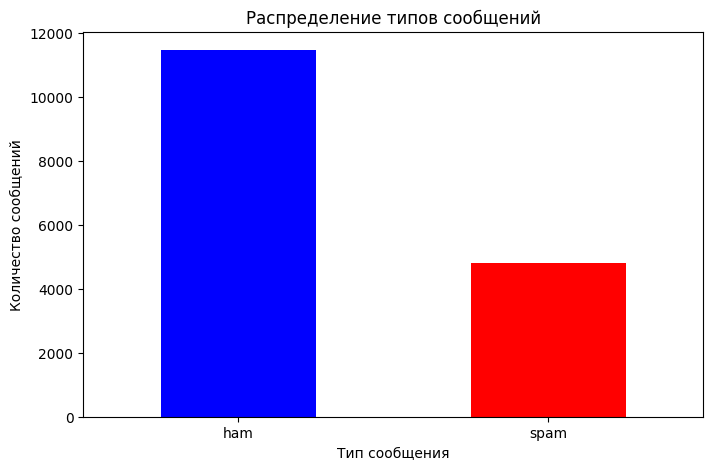

In [14]:
# Визуализация распределения сообщений по типам
plt.figure(figsize=(8, 5))
message_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Распределение типов сообщений')
plt.xlabel('Тип сообщения')
plt.ylabel('Количество сообщений')
plt.xticks(rotation=0)
plt.show()

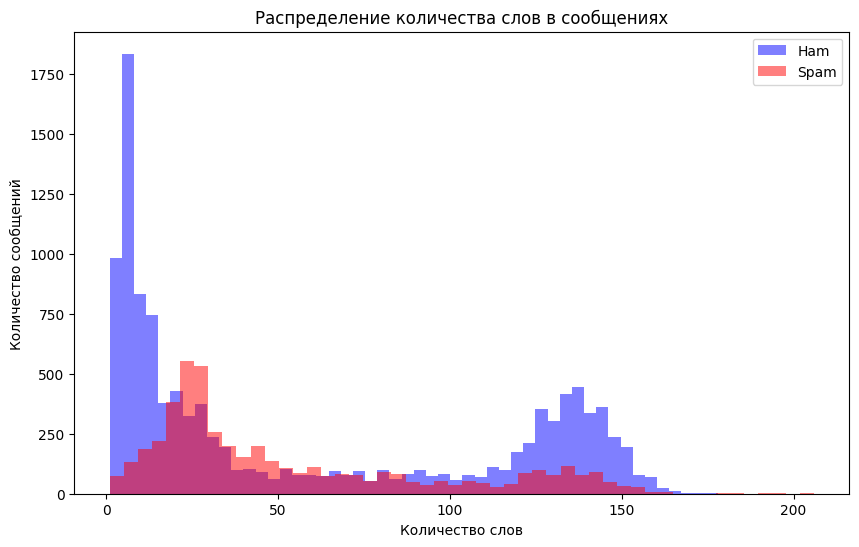

In [15]:
# Расчет количества слов в каждом сообщении
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Визуализация распределения количества слов для каждого типа сообщения
plt.figure(figsize=(10, 6))
plt.hist(df[df['text_type'] == 'ham']['word_count'], bins=50, alpha=0.5, label='Ham', color='blue')
plt.hist(df[df['text_type'] == 'spam']['word_count'], bins=50, alpha=0.5, label='Spam', color='red')
plt.title('Распределение количества слов в сообщениях')
plt.xlabel('Количество слов')
plt.ylabel('Количество сообщений')
plt.legend()
plt.show()

In [16]:
# Расчет средней длины сообщений для каждого типа
average_word_count = df.groupby('text_type')['word_count'].mean()
average_word_count

text_type
ham     58.216443
spam    53.561031
Name: word_count, dtype: float64

In [17]:
# Расчет средней длины слов в каждом сообщении
df['average_word_length'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
# Расчет средней длины слов для каждого типа сообщения
average_word_length = df.groupby('text_type')['average_word_length'].mean()
average_word_length

text_type
ham     4.313291
spam    4.750461
Name: average_word_length, dtype: float64

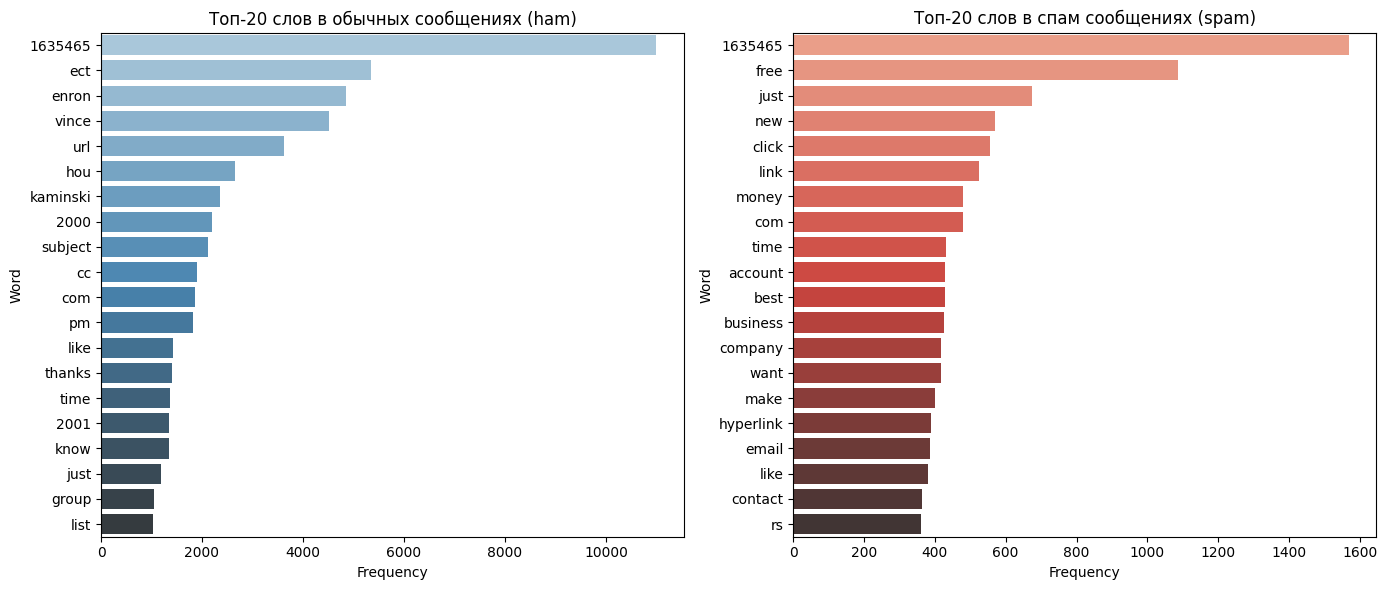

In [18]:
# Создание функции для извлечения наиболее частых слов
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Извлечение и визуализация топ-20 наиболее частых слов для spam и ham сообщений
top_words_ham = get_top_n_words(df[df['text_type'] == 'ham']['text'], 20)
top_words_spam = get_top_n_words(df[df['text_type'] == 'spam']['text'], 20)

# Подготовка данных для визуализации
df_ham_words = pd.DataFrame(top_words_ham, columns=['Word', 'Frequency'])
df_spam_words = pd.DataFrame(top_words_spam, columns=['Word', 'Frequency'])

# Визуализация
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Word', data=df_ham_words, palette='Blues_d')
plt.title('Топ-20 слов в обычных сообщениях (ham)')

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=df_spam_words, palette='Reds_d')
plt.title('Топ-20 слов в спам сообщениях (spam)')

plt.tight_layout()
plt.show()

In [19]:
df = df.drop(columns=['word_count', 'average_word_length'])

## Split dataset

In [20]:
df_train, df_tmp = train_test_split(df, test_size=0.3, random_state=seed)
df_val, df_test = train_test_split(df_tmp, test_size=0.5, random_state=seed)

In [21]:
del df_tmp

In [22]:
df_train.shape, df_val.shape, df_test.shape

((11386, 2), (2440, 2), (2441, 2))

## Preprocess data

In [23]:
def encode_target(df, label_encoder=None):
    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(df['text_type'])
    df['text_type'] = label_encoder.transform(df['text_type'])

    return df, label_encoder

In [24]:
def text_lower(df):
    df['text'] = df['text'].str.lower()
    return df

In [25]:
def remove_punctuation(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

    return df

In [26]:
def remove_stopwords(df):
    stopwords = list(text.ENGLISH_STOP_WORDS)
    def remove(text):
        words = [word for word in text.split() if word not in stopwords]
        return " ".join(words)
    
    df['text'] = df['text'].apply(remove)
    
    return df

In [27]:
def lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    
    def lemmatize_text(text):
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()] 
        return ' '.join(lemmatized_words)

    df['text'] = df['text'].apply(lemmatize_text)
    
    return df

In [28]:
def stemming(df):
    stemmer = PorterStemmer()

    def stemm_text(text):
        stemmed_words = [stemmer.stem(word) for word in text.split()]  
        return ' '.join(stemmed_words)
    
    df['text'] = df['text'].apply(stemm_text)
    
    return df

In [29]:
def preprocess_data(df, label_encoder=None, with_labels=True):
    df = df.copy()
    df = text_lower(df)
    # df = remove_punctuation(df)
    # df = remove_stopwords(df)
    # df = lemmatize(df)
    # df = stemming(df)

    if with_labels:
        df, label_encoder = encode_target(df)

    return df, label_encoder

In [30]:
df_train_prep, label_encoder = preprocess_data(df_train)

In [31]:
df_train_prep.head()

,text_type,text
14713,1,if you have bitcoin wallet chat me for investm...
575,1,🎖pᴜʙɢ mᴏʙɪʟᴇ lɪᴛᴇ hᴀᴄᴋ🎖 ┗❏⚡aɴᴛɪ bᴀɴ ┗❏⚡️esᴘ ┗❏...
6821,1,i am so happy i made the right decision invest...
1808,0,the garp 2001 convention andreas i shall be gl...
8187,0,very hurting n meaningful lines ever i comprom...


In [32]:
df_train_prep.iloc(0)[0]['text']

'if you have bitcoin wallet chat me for investment 50 profit 550 100 profit 1500 200 profit 2500 300 profit 3500 400 profit 4500 500 profit 5500 600 profit 6600 700 profit 7700 profit in 24 hours no hidden charges you can make money online without depending on your salary do you have a pc or a phone try this and gain financial freedom click on the link below👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇 juliabrooks1 juliabrooks1'

In [33]:
df_val_prep, _ = preprocess_data(df_val, label_encoder)

In [34]:
df_test_prep, _ = preprocess_data(df_test, label_encoder)

## TF-IDF

In [35]:
def count_unique_words(df):
    # Объедините все тексты в одну строку
    all_text = ' '.join(df['text'])

    # Разделите текст на слова и подсчитайте их частоту
    words = all_text.split()
    word_counts = pd.Series(words).value_counts()

    # Создайте новый DataFrame с двумя столбцами: слово и его частота
    word_freq_df = pd.DataFrame({'Word': word_counts.index, 'Frequency': word_counts.values})

    return word_freq_df

In [36]:
vocab = count_unique_words(df_train)
vocab.shape

(47190, 2)

In [37]:
vocab.head(300)

,Word,Frequency
0,the,19265
1,to,17595
2,i,11067
3,and,10529
4,a,10148
...,...,...
295,friday,282
296,credit,282
297,line,281
298,l,281


In [38]:
def TFIDF(df, tfidf_vectorizer=None, n_features=None):

      if tfidf_vectorizer is None:
        tfidf_vectorizer = TfidfVectorizer(max_features=n_features)# , min_df=5, max_df=0.9, ngram_range=(1,2)) 
        tfidf_vectorizer.fit(df['text'])
    
      feature_names = tfidf_vectorizer.get_feature_names_out()
      
      tfidf_matrix = tfidf_vectorizer.transform(df['text'])
      tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=feature_names, index=df.index)
    
      return tfidf_df, tfidf_vectorizer

In [39]:
y_train = df_train_prep['text_type']
y_val = df_val_prep['text_type']
y_test = df_test_prep['text_type']

In [40]:
n_feats = 600
X_train_tfidf, tfidf_vectorizer = TFIDF(df_train_prep, n_features=n_feats)

In [41]:
X_train_tfidf.head()

,00,000,01,02,03,04,05,06,07,08,...,wrote,www,year,years,yes,yesterday,yet,you,your,zimin
14713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110517,0.046664,0.0
575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
6821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151824,0.128211,0.0
1808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116102,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139982,0.059105,0.0
8187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [42]:
X_val_tfidf, _ = TFIDF(df_val_prep, tfidf_vectorizer=tfidf_vectorizer, n_features=n_feats)
X_test_tfidf, _ = TFIDF(df_test_prep, tfidf_vectorizer=tfidf_vectorizer, n_features=n_feats)

# Modeling

In [43]:
roc_auc_results = {}

## SVM

In [44]:
svm_model = LinearSVC()

In [45]:
svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

In [46]:
y_pred = svm_model.predict(X_test_tfidf)

In [47]:
roc_auc_svm = roc_auc_score(y_test, y_pred)
roc_auc_results['SVM'] = roc_auc_svm
print(f'ROC AUC Score: {roc_auc_svm}')

ROC AUC Score: 0.8656182750537996


In [48]:
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      1710
           1       0.86      0.79      0.82       731

    accuracy                           0.90      2441
   macro avg       0.88      0.87      0.87      2441
weighted avg       0.90      0.90      0.90      2441



## Naive Bayes

In [49]:
nb_model = MultinomialNB()

In [50]:
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [51]:
y_pred_nb = nb_model.predict(X_test_tfidf)

In [52]:
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)
roc_auc_results['Naive Bayes'] = roc_auc_nb
print(f'ROC AUC Score: {roc_auc_nb}')

ROC AUC Score: 0.8314029487764097


In [53]:
report_nb = classification_report(y_test, y_pred_nb)
print('Classification Report:\n', report_nb)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1710
           1       0.87      0.71      0.78       731

    accuracy                           0.88      2441
   macro avg       0.88      0.83      0.85      2441
weighted avg       0.88      0.88      0.88      2441



## Random Forest

In [54]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)

In [55]:
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=1234)

In [56]:
y_pred_rf = rf_model.predict(X_test_tfidf)

In [57]:
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
roc_auc_results['Random Forest'] = roc_auc_rf
print(f'ROC AUC Score: {roc_auc_rf}')

ROC AUC Score: 0.8692994456044353


In [58]:
report_rf = classification_report(y_test, y_pred_rf)
print('Classification Report:\n', report_rf)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1710
           1       0.91      0.77      0.84       731

    accuracy                           0.91      2441
   macro avg       0.91      0.87      0.89      2441
weighted avg       0.91      0.91      0.91      2441



## Catboost

In [59]:
catboost_model = CatBoostClassifier(iterations=1000, 
                                    learning_rate=0.1, 
                                    depth=6, 
                                    eval_metric='AUC', 
                                    random_seed=seed,
                                    verbose=200)

In [60]:
catboost_model.fit(X_train_tfidf, y_train, 
                   eval_set=(X_val_tfidf, y_val), 
                   use_best_model=True, 
                   early_stopping_rounds=50)

0:	test: 0.7434525	best: 0.7434525 (0)	total: 186ms	remaining: 3m 5s
200:	test: 0.9623882	best: 0.9625140 (199)	total: 5.72s	remaining: 22.7s
400:	test: 0.9675434	best: 0.9676603 (397)	total: 10.8s	remaining: 16.2s
600:	test: 0.9698741	best: 0.9699128 (592)	total: 16.2s	remaining: 10.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9704070313
bestIteration = 735

Shrink model to first 736 iterations.


In [61]:
y_pred_cat = catboost_model.predict(X_test_tfidf)

In [62]:
roc_auc_cat = roc_auc_score(y_test, y_pred_cat)
roc_auc_results['CatBoost'] = roc_auc_cat
print(f'ROC AUC Score: {roc_auc_cat}')

ROC AUC Score: 0.8795593635250918


In [63]:
report_cat = classification_report(y_test, y_pred_cat)
print('Classification Report:\n', report_cat)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      1710
           1       0.91      0.79      0.85       731

    accuracy                           0.92      2441
   macro avg       0.91      0.88      0.89      2441
weighted avg       0.92      0.92      0.91      2441



## XGBoost

In [64]:
xgb_model = XGBClassifier(n_estimators=1000, 
                          learning_rate=0.1, 
                          max_depth=6, 
                          subsample=0.8, 
                          colsample_bytree=0.8,
                          eval_metric='auc',
                          use_label_encoder=False,
                          random_state=seed)

In [65]:
xgb_model.fit(X_train_tfidf, y_train, 
              eval_set=[(X_val_tfidf, y_val)], 
              early_stopping_rounds=50, 
              verbose=100)

C:\Users\user\JupyterLab\Методы анализа данных\DAvenv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71607
[100]	validation_0-auc:0.95309
[200]	validation_0-auc:0.96318
[300]	validation_0-auc:0.96746
[382]	validation_0-auc:0.96769


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=1234, ...)

In [66]:
y_pred_xgb = xgb_model.predict(X_test_tfidf)

In [67]:
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
roc_auc_results['XGBoost'] = roc_auc_xgb
print(f'ROC AUC Score: {roc_auc_xgb}')

ROC AUC Score: 0.8747766017871856


In [68]:
report_xgb = classification_report(y_test, y_pred_xgb)
print('Classification Report:\n', report_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94      1710
           1       0.90      0.79      0.84       731

    accuracy                           0.91      2441
   macro avg       0.91      0.87      0.89      2441
weighted avg       0.91      0.91      0.91      2441



## Logistic Regression

In [69]:
logreg_model = LogisticRegression(max_iter=1000, random_state=seed)

In [70]:
logreg_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=1234)

In [71]:
y_pred_logreg = logreg_model.predict(X_test_tfidf)

In [72]:
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
roc_auc_results['Logistic Regression'] = roc_auc_logreg
print(f'ROC AUC Score: {roc_auc_logreg}')

ROC AUC Score: 0.8541783665730673


In [73]:
report_logreg = classification_report(y_test, y_pred_logreg)
print('Classification Report:\n', report_logreg)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93      1710
           1       0.86      0.76      0.81       731

    accuracy                           0.89      2441
   macro avg       0.88      0.85      0.87      2441
weighted avg       0.89      0.89      0.89      2441



## Stacking Classifier

In [74]:
estimators = [
    ('svc', LinearSVC()),
    ('mnb', MultinomialNB()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=seed)),
    ('catboost', CatBoostClassifier(verbose=0, random_seed=seed))
]

In [75]:
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=seed),
    cv=5
)

In [76]:
stacking_clf.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('svc', LinearSVC()), ('mnb', MultinomialNB()),
                               ('rf',
                                RandomForestClassifier(random_state=1234)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x000001F617DB8920>)],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 devic...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=1234, ...))

In [77]:
y_pred_stack = stacking_clf.predict(X_test_tfidf)

In [78]:
roc_auc_stack = roc_auc_score(y_test, y_pred_stack)
roc_auc_results['Stacking'] = roc_auc_stack
print(f'ROC AUC Score: {roc_auc_stack}')

ROC AUC Score: 0.8898348813209495


In [79]:
report_stack = classification_report(y_test, y_pred_stack)
print('Classification Report:\n', report_stack)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      1710
           1       0.89      0.82      0.86       731

    accuracy                           0.92      2441
   macro avg       0.91      0.89      0.90      2441
weighted avg       0.92      0.92      0.92      2441



## Fully connected NN

In [80]:
class FCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.values
        self.y = y.values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            "inputs" : torch.from_numpy(self.X[idx]),
            "label" : self.y[idx]
        }

In [81]:
train_ds_fc = FCDataset(X_train_tfidf, y_train)
val_ds_fc = FCDataset(X_val_tfidf, y_val)
test_ds_fc = FCDataset(X_test_tfidf, y_test)

In [82]:
class FCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCNN, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(128, output_size),
        )

    def forward(self, x):
        return self.layer(x)

In [83]:
fc_nn = FCNN(train_ds_fc.X.shape[1], len(np.unique(train_ds_fc.y)))

In [84]:
n_epochs = 1000
batch_size = 512
learning_rate = 0.001
patience = 10

In [85]:
train_loader_fc = DataLoader(train_ds_fc, batch_size=batch_size)
val_loader_fc = DataLoader(val_ds_fc, batch_size=batch_size)

In [86]:
optimizer = torch.optim.Adam(fc_nn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

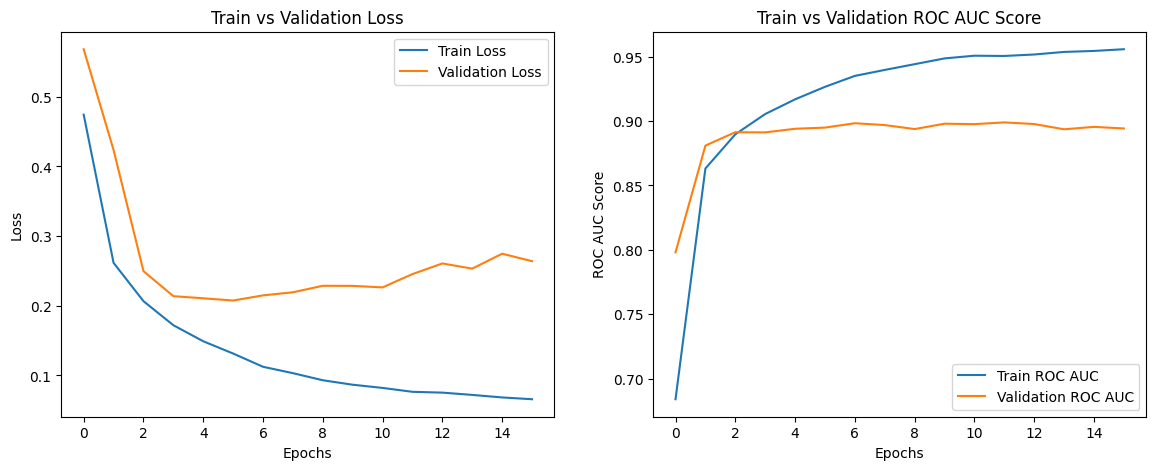

  2%|█▏                                                                              | 15/1000 [00:06<07:31,  2.18it/s]


Epoch 16/1000: Train loss: 0.06595302389367767; Val loss: 0.26402289271354673
Early stopping after 10 epochs without improvement.


In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fc_nn.to(device)

best_val_loss = 1e+10
patience_counter = 0
best_model_state = None

# Initialize lists for plot
train_losses = []
val_losses = []
train_auc_scores = []
val_auc_scores = []

for epoch in tqdm.tqdm(range(n_epochs)):
    fc_nn.train()

    train_loss = []
    val_loss = []

    train_predictions = []
    train_labels = []
    val_predictions = []
    val_labels = []

    for i, batch in enumerate(train_loader_fc):
        inputs = batch['inputs'].to(device).float()
        label = batch['label'].to(device).long()

        optimizer.zero_grad()
        outputs = fc_nn(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        train_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_labels.extend(label.cpu().numpy())

    fc_nn.eval()
    with torch.no_grad():
        val_predictions = []
        val_labels = []
        for i, batch in enumerate(val_loader_fc):
            inputs = batch['inputs'].to(device).float()
            label = batch['label'].to(device).long()
            outputs = fc_nn(inputs)

            loss = criterion(outputs, label)
            val_loss.append(loss.item())

            val_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels.extend(label.cpu().numpy())

    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    train_auc = roc_auc_score(train_labels, train_predictions)
    val_auc = roc_auc_score(val_labels, val_predictions)

    # Append losses and auc scores for plot
    train_losses.append(mean_train_loss)
    val_losses.append(mean_val_loss)
    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)

    # Clear the previous plot
    clear_output(wait=True)

    # Plot losses
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train vs Validation Loss')
    axs[0].legend()

    # Plot ROC AUC scores
    axs[1].plot(train_auc_scores, label='Train ROC AUC')
    axs[1].plot(val_auc_scores, label='Validation ROC AUC')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('ROC AUC Score')
    axs[1].set_title('Train vs Validation ROC AUC Score')
    axs[1].legend()

    plt.show()

    print()
    print(f'Epoch {epoch+1}/{n_epochs}: Train loss: {mean_train_loss}; Val loss: {mean_val_loss}')

    
    if mean_val_loss <= best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0
        best_model_state = fc_nn.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            fc_nn.load_state_dict(best_model_state)
            break
    

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader_fc = DataLoader(test_ds_fc, batch_size=64)

fc_nn = fc_nn.to(device)
fc_nn.eval()
with torch.no_grad():
    test_predictions_fc = []
    test_labels_fc = []

    for i, batch in enumerate(test_loader_fc):
        inputs = batch['inputs'].to(device).float()
        labels = batch['label']
        outputs = fc_nn(inputs).argmax(1)

        test_predictions_fc += outputs.detach().cpu().tolist()
        test_labels_fc += labels.cpu().tolist()

In [89]:
roc_auc_fcnn = roc_auc_score(test_labels_fc, test_predictions_fc)
roc_auc_results['FC NeuralNet'] = roc_auc_fcnn
print(f'ROC AUC Score: {roc_auc_fcnn}')

ROC AUC Score: 0.8956984344125247


In [90]:
report_fcnn = classification_report(test_labels_fc, test_predictions_fc)
print('Classification Report:\n', report_fcnn)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      1710
           1       0.89      0.84      0.86       731

    accuracy                           0.92      2441
   macro avg       0.91      0.90      0.90      2441
weighted avg       0.92      0.92      0.92      2441



## Recurrent NNs

### Prepare data

In [91]:
def preprocess(text):
    return text.split()

In [92]:
def build_vocabulary(texts, min_freq=1, padding_token="_PAD", unknown_token="_UNK"):
    # Builds a vocabulary dictionary mapping words to indices from a corpus of texts
    # Adds special padding and unknown tokens

    counter = Counter()
    for text in tqdm.tqdm(texts):
        words = preprocess(text)
        counter.update(words)
        
    vocab = [padding_token, unknown_token]
    vocab.extend(
        [word for word, freq in counter.items() if freq >= min_freq]  
    )
    
    word2idx = {word: idx for idx, word in enumerate(vocab)}  
    idx2word = {idx: word for idx, word in enumerate(vocab)}
    
    return vocab, word2idx, idx2word

In [93]:
texts = list(df_train_prep['text'].values)  
    
vocab, word2idx, idx2word = build_vocabulary(texts)

100%|████████████████████████████████████████████████████████████████████████| 11386/11386 [00:00<00:00, 137787.57it/s]


In [94]:
len(vocab)

47176

In [95]:
class TextDataset(Dataset):
    def __init__(self, data, word2idx, preprocess, with_labels=True):
        self.data = data.reset_index()
        self.data['text'] = self.data['text'].apply(lambda x: 'empty' if not x.strip() else x) 
        self.preprocess = preprocess
        self.word2idx = word2idx
        self.with_labels = with_labels
        
    def __len__(self,):
        return len(self.data['text'])
        
    def __getitem__(self, idx):
        x = self.data['text'][idx]
        if self.with_labels:
            y = self.data['text_type'][idx]
        else:
            y = None
        # convert text to list that contains indices of it's words 
        # use _UNK token for words that aren't in train dataset
        x = list(map(lambda x: self.word2idx.get(x, self.word2idx['_UNK']), self.preprocess(x)))

        return {
            "inputs": torch.Tensor(x).long(), 
            "label": y
        }

In [96]:
train_ds_rnn = TextDataset(df_train_prep, word2idx, preprocess)
val_ds_rnn = TextDataset(df_val_prep, word2idx, preprocess)
test_ds_rnn = TextDataset(df_test_prep, word2idx, preprocess)

In [97]:
def collate_text_classification(batch):
    
    # Sort batch by sequence length descending
    batch.sort(key=lambda x: len(x['inputs']), reverse=True)

    # Get sequences 
    sequences = [item['inputs'] for item in batch]

    # Save original lengths
    lengths = [len(seq) for seq in sequences]
    
    # Padding 
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    
    # Class labels 
    if batch[0]['label'] is not None:
        labels = torch.stack([torch.tensor(item['label']).long() for item in batch])   
    else:
        labels = None
    
    return {
            "inputs": padded_sequences,
            "labels": labels,
            "lengths": torch.Tensor(lengths)
    }

In [98]:
batch_size = 512

train_loader_rnn = DataLoader(train_ds_rnn, collate_fn=collate_text_classification, batch_size=batch_size)
val_loader_rnn = DataLoader(val_ds_rnn, collate_fn=collate_text_classification, batch_size=batch_size)
test_loader_rnn = DataLoader(test_ds_rnn, collate_fn=collate_text_classification, batch_size=batch_size)

### RNN

In [99]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        # Word Embedding transforms each word's index in batch['input'] 
        # in vector (size = embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # RNN layer. Specified parameters are: input size, hidden size, num_layers (to use some stacked RNNs)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True) 
        # FullyConnected layer applies to hidden state of last RNN's layer to determine class 
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, lengths):
        # Apply embeddings layer
        x = self.embedding(x)

        # Use pack_padded_sequence to show RNN real sequence legth (using mask)
        packed_input = pack_padded_sequence(x, lengths, batch_first=True)
        # RNN takes as input packed embeddings
        packed_output, hidden = self.rnn(packed_input)
        # _, hidden = self.rnn(packed_input)
        # output, _ = pad_packed_sequence(packed_output, batch_first=True)   

        # Use only hidden state of last layer as input for FC layer
        hidden = self.dropout(hidden[-1,:,:])  
        output = self.fc(hidden)
        
        # Use output to determine class
        return output

In [100]:
rnn_model = RNNClassifier(len(word2idx), 
                       embedding_dim=int(np.sqrt(len(word2idx))), 
                       hidden_dim=128, 
                       output_dim=len(np.unique(train_ds_rnn.data['text_type'])), 
                       n_layers=2,  
                       dropout=0.4)

In [101]:
n_epochs = 1000
learning_rate = 5e-5
patience = 20

In [102]:
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

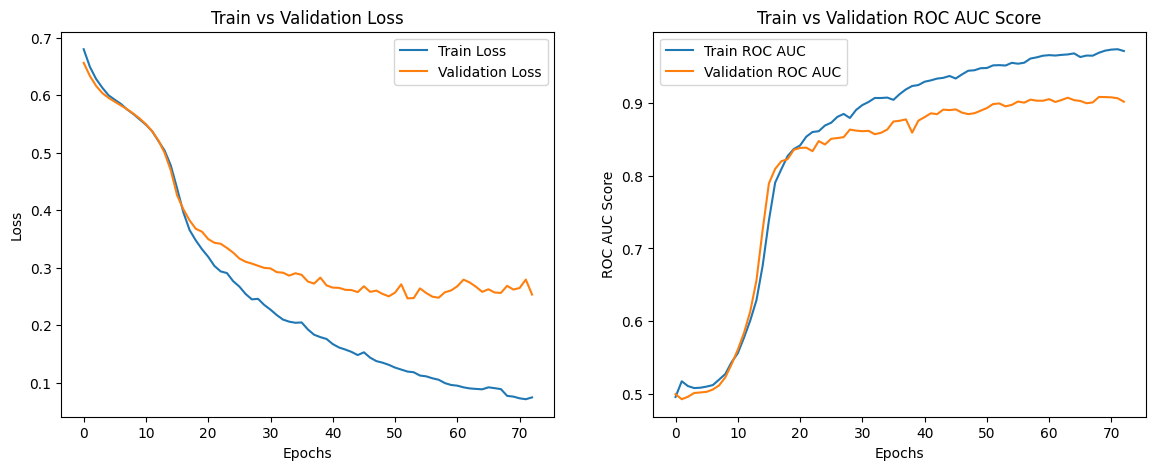

  7%|█████▊                                                                          | 72/1000 [02:53<37:20,  2.41s/it]


Epoch 73/1000: Train loss: 0.07459446022529966; Val loss: 0.25343618988990785
Early stopping after 20 epochs without improvement.


In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rnn_model.to(device)

best_val_loss = 1e+10
patience_counter = 0
best_model_state = None

# Initialize lists for plot
train_losses = []
val_losses = []
train_auc_scores = []
val_auc_scores = []

for epoch in tqdm.tqdm(range(n_epochs)):
    rnn_model.train()

    train_loss = []
    val_loss = []

    train_predictions = []
    train_labels = []
    val_predictions = []
    val_labels = []

    for i, batch in enumerate(train_loader_rnn):
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        lengths = batch['lengths']

        optimizer.zero_grad()
        outputs = rnn_model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        train_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    rnn_model.eval()
    with torch.no_grad():
        val_predictions = []
        val_labels = []
        for i, batch in enumerate(val_loader_rnn):
            inputs = batch['inputs'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']
            outputs = rnn_model(inputs, lengths)

            loss = criterion(outputs, labels)
            val_loss.append(loss.item())

            val_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    train_auc = roc_auc_score(train_labels, train_predictions, average='macro')
    val_auc = roc_auc_score(val_labels, val_predictions, average='macro')

    train_losses.append(mean_train_loss)
    val_losses.append(mean_val_loss)
    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)
    
    clear_output(wait=True)

    
    # Plot losses
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train vs Validation Loss')
    axs[0].legend()

    # Plot ROC AUC scores
    axs[1].plot(train_auc_scores, label='Train ROC AUC')
    axs[1].plot(val_auc_scores, label='Validation ROC AUC')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('ROC AUC Score')
    axs[1].set_title('Train vs Validation ROC AUC Score')
    axs[1].legend()

    plt.show()
    
    print()
    print(f'Epoch {epoch+1}/{n_epochs}: Train loss: {mean_train_loss}; Val loss: {mean_val_loss}')

    
    if mean_val_loss <= best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0
        best_model_state = rnn_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            rnn_model.load_state_dict(best_model_state)
            break

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rnn_model = rnn_model.to(device)
rnn_model.eval()
with torch.no_grad():
    test_predictions_rnn = []
    test_labels_rnn = []

    for i, batch in enumerate(test_loader_rnn):
        inputs = batch['inputs'].to(device)
        labels = batch['labels']
        lengths = batch['lengths']
        outputs = rnn_model(inputs, lengths).argmax(1)

        test_predictions_rnn += outputs.detach().cpu().tolist()
        test_labels_rnn += labels.cpu().tolist()

In [105]:
roc_auc_rnn = roc_auc_score(test_labels_rnn, test_predictions_rnn)
roc_auc_results['RNN'] = roc_auc_rnn
print(f'ROC AUC Score: {roc_auc_rnn}')

ROC AUC Score: 0.9019587843297254


In [106]:
report_rnn = classification_report(test_labels_rnn, test_predictions_rnn)
print('Classification Report:\n', report_rnn)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      1710
           1       0.88      0.85      0.87       731

    accuracy                           0.92      2441
   macro avg       0.91      0.90      0.91      2441
weighted avg       0.92      0.92      0.92      2441



### Bidirectional LSTM

In [107]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Set bidirectional=True and dropout=dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout, batch_first=True)
        # FC layer's input size = LSTM's hidden size because this LSTM is Biderictional
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        x = self.embedding(x)
        
        packed_sequence = pack_padded_sequence(x, lengths, batch_first=True)
        # Ignore LSTM output on each step and cell state (long term memory)
        # Use for further steps only hidden state (short term memory)
        _, (hidden, _) = self.lstm(packed_sequence)
        # output, (hidden, cell_state) = self.lstm(packed_sequence)

        # hidden[-1,:,:] - reverse hidden state for last layer
        # hidden[-2,:,:] - forward hidden state for last layer
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
 
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        
        return output

In [108]:
lstm_model = LSTMClassifier(len(word2idx), 
                       embedding_dim=int(np.sqrt(len(word2idx))), 
                       hidden_dim=128, 
                       output_dim=len(np.unique(train_ds_rnn.data['text_type'])), 
                       n_layers=2,  
                       dropout=0.4)

In [109]:
n_epochs = 1000
learning_rate = 5e-5
patience = 10

In [110]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

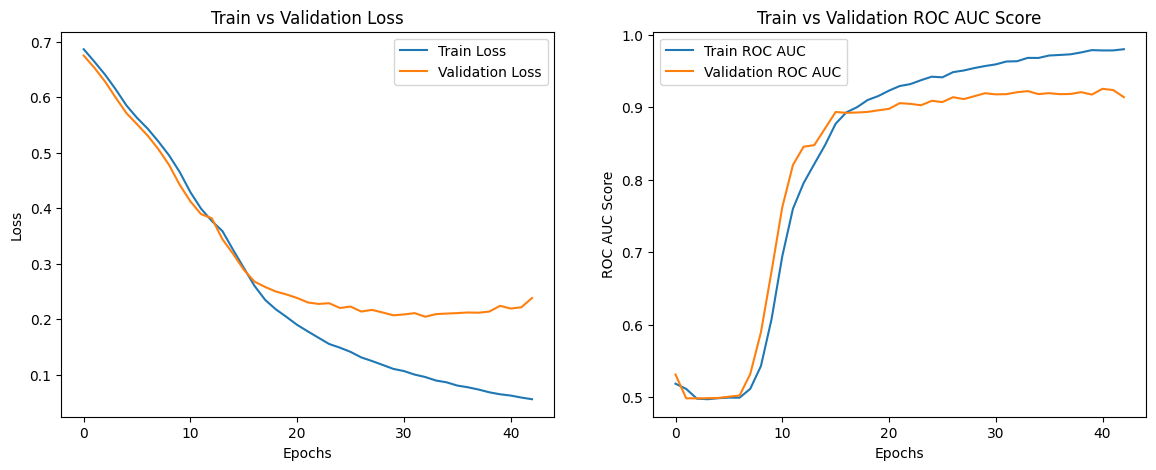

  4%|███▎                                                                          | 42/1000 [06:01<2:17:28,  8.61s/it]


Epoch 43/1000: Train loss: 0.056122577789685; Val loss: 0.23851951956748962
Early stopping after 10 epochs without improvement.


In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm_model.to(device)

best_val_loss = 1e+10
patience_counter = 0
best_model_state = None

# Initialize lists for plot
train_losses = []
val_losses = []
train_auc_scores = []
val_auc_scores = []

for epoch in tqdm.tqdm(range(n_epochs)):
    lstm_model.train()

    train_loss = []
    val_loss = []

    train_predictions = []
    train_labels = []
    val_predictions = []
    val_labels = []

    for i, batch in enumerate(train_loader_rnn):
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        lengths = batch['lengths']

        optimizer.zero_grad()
        outputs = lstm_model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        train_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    lstm_model.eval()
    with torch.no_grad():
        val_predictions = []
        val_labels = []
        for i, batch in enumerate(val_loader_rnn):
            inputs = batch['inputs'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']
            outputs = lstm_model(inputs, lengths)

            loss = criterion(outputs, labels)
            val_loss.append(loss.item())

            val_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    train_auc = roc_auc_score(train_labels, train_predictions, average='macro')
    val_auc = roc_auc_score(val_labels, val_predictions, average='macro')

    train_losses.append(mean_train_loss)
    val_losses.append(mean_val_loss)
    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)
    
    clear_output(wait=True)

    
    # Plot losses
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train vs Validation Loss')
    axs[0].legend()

    # Plot ROC AUC scores
    axs[1].plot(train_auc_scores, label='Train ROC AUC')
    axs[1].plot(val_auc_scores, label='Validation ROC AUC')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('ROC AUC Score')
    axs[1].set_title('Train vs Validation ROC AUC Score')
    axs[1].legend()

    plt.show()
    
    print()
    print(f'Epoch {epoch+1}/{n_epochs}: Train loss: {mean_train_loss}; Val loss: {mean_val_loss}')

    
    if mean_val_loss <= best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0
        best_model_state = lstm_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            lstm_model.load_state_dict(best_model_state)
            break

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm_model = lstm_model.to(device)
lstm_model.eval()
with torch.no_grad():
    test_predictions_lstm = []
    test_labels_lstm = []

    for i, batch in enumerate(test_loader_rnn):
        inputs = batch['inputs'].to(device)
        labels = batch['labels']
        lengths = batch['lengths']
        outputs = lstm_model(inputs, lengths).argmax(1)

        test_predictions_lstm += outputs.detach().cpu().tolist()
        test_labels_lstm += labels.cpu().tolist()

In [113]:
roc_auc_lstm = roc_auc_score(test_labels_lstm, test_predictions_lstm)
roc_auc_results['LSTM'] = roc_auc_lstm
print(f'ROC AUC Score: {roc_auc_lstm}')

ROC AUC Score: 0.9125006999944


In [114]:
report_lstm = classification_report(test_labels_lstm, test_predictions_lstm)
print('Classification Report:\n', report_lstm)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1710
           1       0.90      0.87      0.88       731

    accuracy                           0.93      2441
   macro avg       0.92      0.91      0.92      2441
weighted avg       0.93      0.93      0.93      2441



### GRU

In [115]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        x = self.embedding(x)
        
        packed_sequence = pack_padded_sequence(x, lengths, batch_first=True)
        _, hidden = self.gru(packed_sequence)
        
        hidden = hidden[-1,:,:]
 
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        
        return output

In [116]:
gru_model = GRUClassifier(len(word2idx), 
                       embedding_dim=int(np.sqrt(len(word2idx))), 
                       hidden_dim=128, 
                       output_dim=len(np.unique(train_ds_rnn.data['text_type'])),
                       n_layers=2,  
                       dropout=0.4)

In [117]:
n_epochs = 1000
learning_rate = 3e-5
patience = 10

In [118]:
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

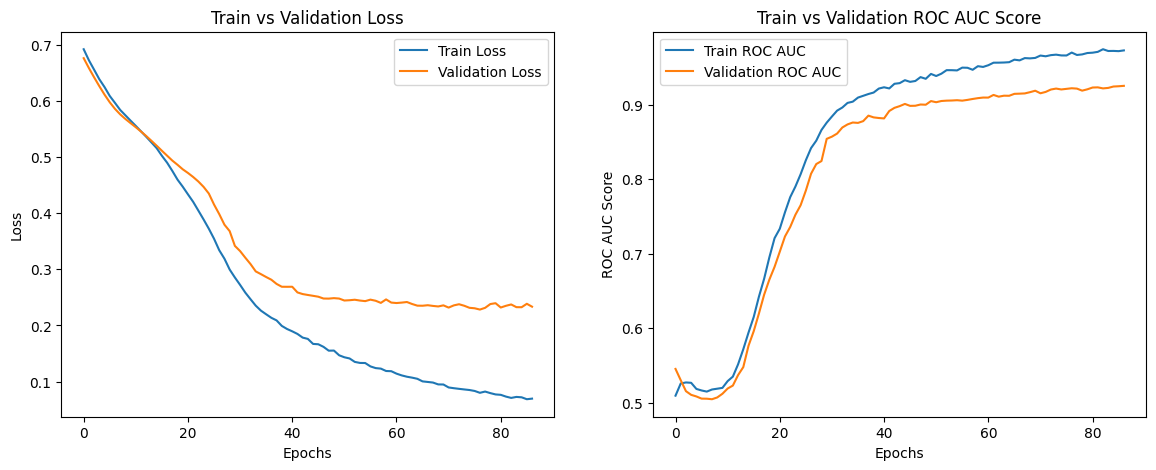

  9%|██████▉                                                                         | 86/1000 [03:48<40:28,  2.66s/it]


Epoch 87/1000: Train loss: 0.06953780458349249; Val loss: 0.23346332609653472
Early stopping after 10 epochs without improvement.


In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gru_model.to(device)

best_val_loss = 1e+10
patience_counter = 0
best_model_state = None

# Initialize lists for plot
train_losses = []
val_losses = []
train_auc_scores = []
val_auc_scores = []

for epoch in tqdm.tqdm(range(n_epochs)):
    gru_model.train()

    train_loss = []
    val_loss = []

    train_predictions = []
    train_labels = []
    val_predictions = []
    val_labels = []

    for i, batch in enumerate(train_loader_rnn):
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        lengths = batch['lengths']

        optimizer.zero_grad()
        outputs = gru_model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        train_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    gru_model.eval()
    with torch.no_grad():
        val_predictions = []
        val_labels = []
        for i, batch in enumerate(val_loader_rnn):
            inputs = batch['inputs'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']
            outputs = gru_model(inputs, lengths)

            loss = criterion(outputs, labels)
            val_loss.append(loss.item())

            val_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    train_auc = roc_auc_score(train_labels, train_predictions, average='macro')
    val_auc = roc_auc_score(val_labels, val_predictions, average='macro')

    train_losses.append(mean_train_loss)
    val_losses.append(mean_val_loss)
    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)
    
    clear_output(wait=True)

    
    # Plot losses
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train vs Validation Loss')
    axs[0].legend()

    # Plot ROC AUC scores
    axs[1].plot(train_auc_scores, label='Train ROC AUC')
    axs[1].plot(val_auc_scores, label='Validation ROC AUC')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('ROC AUC Score')
    axs[1].set_title('Train vs Validation ROC AUC Score')
    axs[1].legend()

    plt.show()
    
    print()
    print(f'Epoch {epoch+1}/{n_epochs}: Train loss: {mean_train_loss}; Val loss: {mean_val_loss}')

    
    if mean_val_loss <= best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0
        best_model_state = gru_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            gru_model.load_state_dict(best_model_state)
            break

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gru_model = gru_model.to(device)
gru_model.eval()
with torch.no_grad():
    test_predictions_gru = []
    test_labels_gru = []

    for i, batch in enumerate(test_loader_rnn):
        inputs = batch['inputs'].to(device)
        labels = batch['labels']
        lengths = batch['lengths']
        outputs = gru_model(inputs, lengths).argmax(1)

        test_predictions_gru += outputs.detach().cpu().tolist()
        test_labels_gru += labels.cpu().tolist()

In [121]:
roc_auc_gru = roc_auc_score(test_labels_gru, test_predictions_gru)
roc_auc_results['GRU'] = roc_auc_gru
print(f'ROC AUC Score: {roc_auc_gru}')

ROC AUC Score: 0.9175966592267263


In [122]:
report_gru = classification_report(test_labels_gru, test_predictions_gru)
print('Classification Report:\n', report_gru)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1710
           1       0.88      0.89      0.88       731

    accuracy                           0.93      2441
   macro avg       0.92      0.92      0.92      2441
weighted avg       0.93      0.93      0.93      2441



# Select best model

In [123]:
roc_auc_df = pd.DataFrame(list(roc_auc_results.items()), columns=['Model', 'ROC AUC Score'])

In [124]:
roc_auc_df = roc_auc_df.sort_values(by='ROC AUC Score', ascending=False)

In [125]:
roc_auc_df

,Model,ROC AUC Score
10,GRU,0.917597
9,LSTM,0.912501
8,RNN,0.901959
7,FC NeuralNet,0.895698
6,Stacking,0.889835
3,CatBoost,0.879559
4,XGBoost,0.874777
2,Random Forest,0.869299
0,SVM,0.865618
5,Logistic Regression,0.854178


# Predict for test_spam.csv (without labels)

In [126]:
predict_df = pd.read_csv('data/test_spam.csv')

In [127]:
predict_df.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [128]:
predict_df_prep, _ = preprocess_data(predict_df, label_encoder, with_labels=False)

In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gru_model = gru_model.to(device)
gru_model.eval()
with torch.no_grad():
    test_predictions = []

    for i in range(predict_df_prep.shape[0]):
        text = predict_df_prep.iloc(0)[i].item()
        if text == '':
            text = 'empty'
        x = list(map(lambda text: word2idx.get(text, word2idx['_UNK']), preprocess(text)))
        inputs = torch.Tensor(x).long()
        inputs = pad_sequence([inputs], batch_first=True, padding_value=0)
        
        inputs = inputs.to(device)
        lengths = torch.tensor([len(x)]).long()
        outputs = gru_model(inputs, lengths).argmax(1)

        test_predictions += outputs.detach().cpu().tolist()

In [130]:
predict_df['text_type'] = label_encoder.inverse_transform(test_predictions)

In [133]:
predict_df.head(98)

,text,text_type
0,j jim whitehead ejw cse ucsc edu writes j you ...,ham
1,original message from bitbitch magnesium net p...,ham
2,java for managers vince durasoft who just taug...,ham
3,there is a youtuber name saiman says,ham
4,underpriced issue with high return on equity t...,spam
...,...,...
93,ftr team the copy of the auction results that ...,ham
94,join our group 🍆🔞🔞🔞🔞🔞🔞🔞🔞🔞🔞,spam
95,idea please take a look dear mr kaminski thank...,spam
96,robert harley writes ok then consider a popula...,ham


In [134]:
predict_df.to_csv('result.csv', index=False)